# 期末大作业：基于深度学习的细胞类型聚类


成员：张铭徐(2113615) 张惠程(2112241)


## Motivation

现如今二代测序技术可以测得生物体大量的的组学数据信息，如基因组数据、转录组数据以及蛋白组数据，其为了解生物体的调控机理提供了数据基础。然而对于生物数据的标注一直是一个难题，对于转录组数据，其通常是来分析细胞群的marker基因来给细胞群体进行标注，但是这需要耗费大量的人力和财力 。机器学习为生物数据标注提供了很大的便捷，其可以通过一些算法（如最简单的层次聚类、Kmeans等）先为数据标注一个大致正确的伪标签，为后续生物学家进行真实细胞类型的标注提供了参考。
         

## Dataset
我们这次使用转录组数据作为数据集来完成这次任务，转录组数据本质上是一个稀疏矩阵$X$，其大小为$n*m$，$n$代表细胞总数，$m$代表基因表达的数量，其本质是一个基因表达矩阵，$X_{i,j}$代表第$i$个细胞在第$j$个基因上的表达量。此次需要提交一个细胞聚类的编号文件，（聚类编号从0到$k$，$k$为算法计算的$k$个潜在细胞群）。请按照给定的基因表达矩阵的细胞数据顺序提交最后的结果。我们将会用Adjusted Rand Score来评价你的结果。

实验数据：dataset1（无真实标签）、dataset2（有真实细胞类型标签）。

## 要求：

- 基础要求(20)：使用简单的深度学习的方法对数据进行细胞类型聚类，得到多个亚群，完成实验报告（最好使用ipynb文件，包括但不限于代码、模型设计思路、模型架构图、聚类效果展示、实验分析等），并以csv文件提交最终的dataset1数据聚类结果（聚类编号从0到k，k为算法计算的k个潜在细胞群）。

- 中级要求(5)：使用你的方法在dataset2上做实验，dataset2有真实的细胞类型标签，你可以对你的方法进行自我评估，并且分析结果，可以体现你的模型改进过程。展示你计算的Adjusted Rand Score指标。

- 高级要求(5): 使用较为复杂的神经网络进行细胞类型聚类。如复现相关论文，用到你的网络中进行复现等。

- 加分项(5)：基础要求的结果会通过Adjusted Rand Score指标进行评分，排名靠前会有额外得分。

- 注意dataset1和dataset2虽然是同属于转录组数据，但是之间存在批次效应，最好不要考虑参考dataset2的真实标签来调整dataset1的结果。该任务是无监督的聚类任务，其训练集和测试集是一致的，不是传统的需要划分训练、验证和测试集的任务。
         


In [18]:
# 引入头文件
import anndata as ad
import scanpy as sc
import numpy as np
from anndata import AnnData
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, homogeneity_score, completeness_score, v_measure_score
from sklearn.metrics.cluster import contingency_matrix
from scipy.optimize import linear_sum_assignment
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.decomposition import PCA

In [19]:
# Load Dataset

dataset1_path = 'dataset1.h5ad'
dataset2_path = 'dataset2.h5ad'
adata = ad.read_h5ad(dataset1_path)
adata2 = ad.read_h5ad(dataset2_path)

我们首先先通过PCA降维等方法近似的看一下数据的分布以及大概的类别情况

c:\Users\张铭徐\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_pca.py:229: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm['X_pca'] = X_pca
c:\Users\张铭徐\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\张铭徐\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


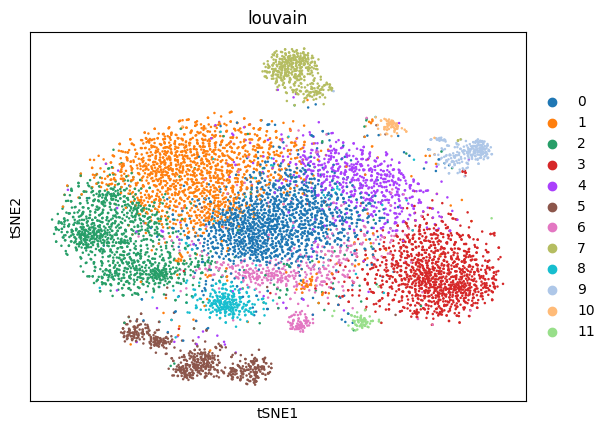

c:\Users\张铭徐\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


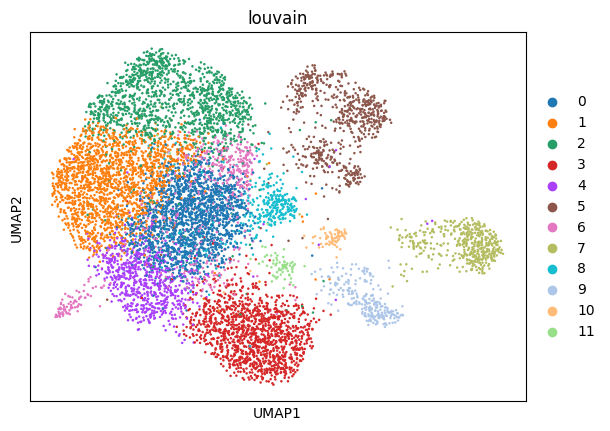

In [20]:
# Visualize Dataset
sc.pp.filter_cells(adata2, min_genes=200)   # 筛选至少包含 200 个基因的细胞
sc.pp.filter_genes(adata2, min_cells=3)     # 筛选至少在 3 个细胞中出现的基因
sc.pp.normalize_total(adata2, target_sum=1e4)  # 数据标准化
sc.pp.log1p(adata2)  # 对数据进行对数转换
sc.pp.highly_variable_genes(adata2, n_top_genes=2000)  # 检测高变异基因
adata2 = adata2[:, adata2.var.highly_variable]  # 保留高变异基因

# 降维分析（PCA）
sc.tl.pca(adata2, svd_solver='arpack')

# 计算邻居图
sc.pp.neighbors(adata2)

# 聚类
sc.tl.louvain(adata2)

# 进行 t-SNE 可视化
sc.tl.tsne(adata2)
sc.pl.tsne(adata2, color='louvain')

# 进行 UMAP 可视化
sc.tl.umap(adata2)
sc.pl.umap(adata2, color='louvain')

In [21]:
rna = ad.read_h5ad("dataset2.h5ad")
rna.X

<9190x28930 sparse matrix of type '<class 'numpy.float32'>'
	with 8633857 stored elements in Compressed Sparse Row format>

c:\Users\张铭徐\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
c:\Users\张铭徐\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


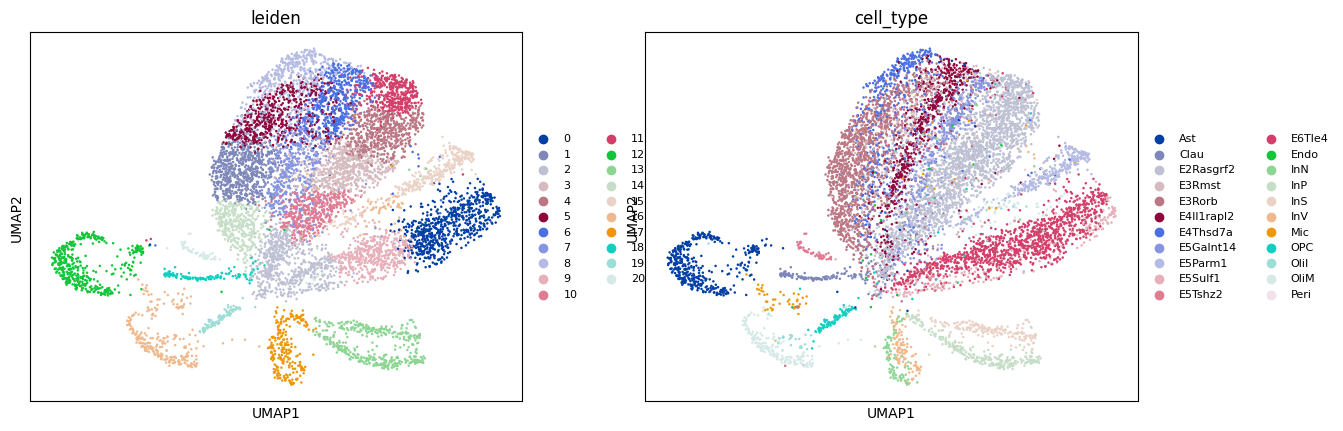

In [22]:
# 读取.h5ad格式的数据文件
rna = ad.read_h5ad("dataset2.h5ad")

# 对基因进行过滤，只保留在至少3个细胞中表达的基因
sc.pp.filter_genes(rna, min_cells=3)

# 对数据进行对数转换，通常是为了减少高表达基因的影响并改善数据的正态分布
sc.pp.log1p(rna)

# 数据标准化处理，对每个基因的表达水平进行缩放以使其具有类似的方差
sc.pp.scale(rna, max_value=10)

# 进行主成分分析（PCA），为后续的降维和聚类提供基础，这里计算前30个主成分
sc.pp.pca(rna, n_comps=50, svd_solver='arpack')

# 计算邻居图，基于PCA结果，这是后续聚类和降维的基础
sc.pp.neighbors(rna, use_rep='X_pca')

# 运用UMAP算法进行降维，以便于可视化高维数据
sc.tl.umap(rna)

# 进行聚类分析，这里使用Leiden算法
sc.tl.leiden(rna, resolution=1.5)

# 使用UMAP结果进行可视化，通过颜色区分不同的聚类结果（Leiden算法得到的聚类）和细胞类型
sc.pl.umap(rna, color=["leiden", "cell_type"], legend_fontsize=8)

In [23]:

# 假设 rna.obs['cell_type'] 存储了原始标签
true_labels = rna.obs['cell_type']
predicted_labels = rna.obs['leiden']

# 计算 ARI
ari_score = adjusted_rand_score(true_labels, predicted_labels)
print(f'Adjusted Rand Index (ARI): {ari_score}')

# 计算 ACC 的辅助函数
def calculate_accuracy(true_labels, predicted_labels):
    contingency = contingency_matrix(true_labels, predicted_labels)
    row_ind, col_ind = linear_sum_assignment(-contingency)
    return contingency[row_ind, col_ind].sum() / np.sum(contingency)

# 计算 ACC
acc_score = calculate_accuracy(true_labels, predicted_labels)
print(f'Accuracy (ACC): {acc_score}')


Adjusted Rand Index (ARI): 0.33638303338888487
Accuracy (ACC): 0.45342763873775843


我们可以看到，实际上对于第二个数据集而言，他自带的聚类算法一共聚类了27类，而实际上我们有22个类，相对效果就不是很好了，事实上，我们考虑聚类，聚类的本质是无监督学习，我们通过学习数据的特征分布，将具有相同数据分布的细胞划分为一类，那么我们最重要的事情就是如何学习数据的分布？

我们还有一个问题在于，当前数据是一个稀疏矩阵，稀疏矩阵的规模特别大，是29830这么多，也就是9000多个细胞有接近3w个属性，显然如果属性较多，训练集较少，是根本无法直接进行学习特征的，并且由于矩阵是稀疏的，我们需要进行一些特征工程，提取对应的有效特征后再进行实验，所以我们的根本目标就在于，如何提取大量属性中的关键属性/信息？

In [24]:
rna.obs

,domain,cell_type,leiden
cells,,,
09L_GTTAGAACAGAT_RNA,scRNA-seq,E6Tle4,0
09I_CATAGCTCAACG_RNA,scRNA-seq,E2Rasgrf2,7
09G_TTACAGGCAGGT_RNA,scRNA-seq,InP,13
09B_CTATGGGCGTGC_RNA,scRNA-seq,E4Il1rapl2,6
09L_AGTGATTGTTCG_RNA,scRNA-seq,Peri,2
...,...,...,...
09E_CCTGCTCGTCAC_RNA,scRNA-seq,Peri,3
09E_TGAGCACCTCCT_RNA,scRNA-seq,E5Parm1,15
09E_CCGGACTCGATC_RNA,scRNA-seq,E3Rorb,2


In [25]:
# see the detail of dataset
print(adata)
print(adata.X)        # 基因表达矩阵

AnnData object with n_obs × n_vars = 9631 × 29095
  (0, 19)	1.0
  (0, 22)	1.0
  (0, 70)	1.0
  (0, 85)	1.0
  (0, 93)	1.0
  (0, 124)	3.0
  (0, 126)	5.0
  (0, 167)	1.0
  (0, 180)	2.0
  (0, 192)	2.0
  (0, 213)	1.0
  (0, 238)	1.0
  (0, 248)	1.0
  (0, 275)	1.0
  (0, 290)	1.0
  (0, 299)	2.0
  (0, 324)	1.0
  (0, 330)	1.0
  (0, 331)	2.0
  (0, 349)	1.0
  (0, 354)	1.0
  (0, 357)	1.0
  (0, 360)	1.0
  (0, 388)	1.0
  (0, 393)	1.0
  :	:
  (9630, 28882)	1.0
  (9630, 28917)	2.0
  (9630, 28982)	1.0
  (9630, 28987)	1.0
  (9630, 28988)	2.0
  (9630, 28992)	1.0
  (9630, 28999)	1.0
  (9630, 29004)	1.0
  (9630, 29007)	20.0
  (9630, 29009)	2.0
  (9630, 29023)	1.0
  (9630, 29041)	1.0
  (9630, 29070)	17.0
  (9630, 29071)	40.0
  (9630, 29072)	26.0
  (9630, 29073)	50.0
  (9630, 29074)	4.0
  (9630, 29075)	59.0
  (9630, 29076)	35.0
  (9630, 29077)	37.0
  (9630, 29078)	1.0
  (9630, 29079)	28.0
  (9630, 29080)	9.0
  (9630, 29081)	1.0
  (9630, 29082)	29.0


In [26]:
rna = ad.read_h5ad("dataset2.h5ad")

In [66]:

sc.pp.filter_genes(rna, min_cells=3)
X_data = rna.X
X_dense = X_data.toarray()
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_dense)
n_components = 30  # 例如，保留前50个主成分
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)

一种比较显然的方法是利用主成分分析PCA，先进行一定程度上的数据降维+标准化，我们原本有3w个属性，我们先通过主成分分析近似的筛选出一些类别，减少一些维度后，在考虑一些事情。

事实上，我们最开始在进行初步先验的时候，就是用的类似方法，先对数据进行一些初步的预处理，然后使用自带的聚类方法直接聚类，这种方法很简单粗暴，所以效果不那么好。

我们的更改在于后续考虑引入Deep Learning，Deep Learning方法的好处在于深度神经网络可以有效的学习数据的分布，提取对应的特征，所以我们考虑引入Auto-Encoder。论文《Deep learning-based clustering approaches for bioinformatics》中也提到了Auto-Encoder在处理聚类问题上的优越性，具体来说，我们的思路是，首先我们将数据输入到Auto-Encoder中，由于AE实际上是一个良好的特征学习器，在图像生成等领域具有一些优势，我们通过一系列的层学习到数据的低维分布(特征)，也就是encoder的过程，然后通过decoder解码为原本的数据，通过不断优化decoder的数据和原始数据的差异，最终得到了一个比较不错的特征学习器，我们通过这个低纬度表示，进行聚类分析，就实现了原本的痛点——如何学习到数据的特征并降维

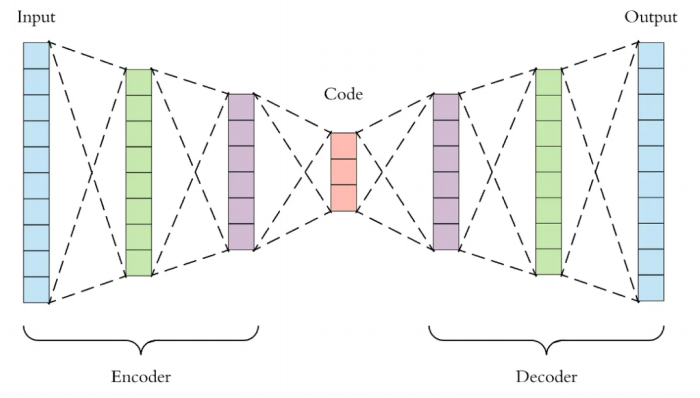

In [85]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model

input_dim = n_components  # 确保 n_components 已被正确设置

# 编码器
input_layer = Input(shape=(input_dim,))
encoder = Dense(units=128, activation='relu')(input_layer)
encoder = Dense(units=128, activation='relu')(encoder)

# 编码表示
encoded = Dense(units=40, activation='relu')(encoder)

# 解码器
decoder = Dense(units=128, activation='relu')(encoded)
decoder = Dense(units=128, activation='relu')(decoder)

# 输出层
output_layer = Dense(units=input_dim, activation='sigmoid')(decoder)

# 构建自编码器模型



In [86]:
import random
import tensorflow as tf
import numpy as np
import os

seed_value = 2211
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

# ... 构建自编码器模型 ...
autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer='adam', loss='mse')
# 然后训练模型
autoencoder.fit(X_pca, X_pca, epochs=300, batch_size=256, shuffle=True, validation_split=0.15)


Epoch 1/300
31/31 [==============================] - 0s 7ms/step - loss: 0.2349 - val_loss: 0.1289
Epoch 2/300
31/31 [==============================] - 0s 4ms/step - loss: 0.1276 - val_loss: 0.1279
Epoch 3/300
31/31 [==============================] - 0s 5ms/step - loss: 0.1265 - val_loss: 0.1262
Epoch 4/300
31/31 [==============================] - 0s 4ms/step - loss: 0.1251 - val_loss: 0.1256
Epoch 5/300
31/31 [==============================] - 0s 4ms/step - loss: 0.1243 - val_loss: 0.1245
Epoch 6/300
31/31 [==============================] - 0s 5ms/step - loss: 0.1221 - val_loss: 0.1201
Epoch 7/300
31/31 [==============================] - 0s 4ms/step - loss: 0.1176 - val_loss: 0.1159
Epoch 8/300
31/31 [==============================] - 0s 4ms/step - loss: 0.1152 - val_loss: 0.1150
Epoch 9/300
31/31 [==============================] - 0s 4ms/step - loss: 0.1146 - val_loss: 0.1143
Epoch 10/300
31/31 [==============================] - 0s 4ms/step - loss: 0.1138 - val_loss: 0.1137
Epoch 11/

In [87]:
# 编码器模型
encoder_model = Model(inputs=input_layer, outputs=encoded)
encoded_data = autoencoder.predict(X_pca)


288/288 [==============================] - 0s 915us/step


In [88]:

# encoded_data = scaler.fit_transform(encoded_data)
encoded_data

array([[1.00000000e+00, 6.98003769e-02, 9.95206416e-01, ...,
        1.22713420e-04, 8.40264112e-02, 8.33302438e-01],
       [1.21374987e-05, 2.09332928e-02, 3.11731803e-03, ...,
        8.36663507e-03, 5.18266243e-05, 4.80095856e-02],
       [1.39020385e-05, 4.29668307e-01, 3.17741573e-01, ...,
        4.38689031e-02, 1.50642142e-01, 5.07124811e-02],
       ...,
       [7.43036033e-09, 5.82758366e-06, 5.31432452e-03, ...,
        1.71152614e-02, 2.62129121e-03, 1.05506048e-01],
       [5.62026471e-05, 2.89754957e-01, 2.55049599e-07, ...,
        9.53500643e-02, 3.54069960e-03, 1.40981272e-01],
       [1.41817758e-08, 3.99063639e-02, 3.02264512e-01, ...,
        1.06642013e-02, 5.58247697e-03, 1.21148936e-01]], dtype=float32)

c:\Users\张铭徐\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


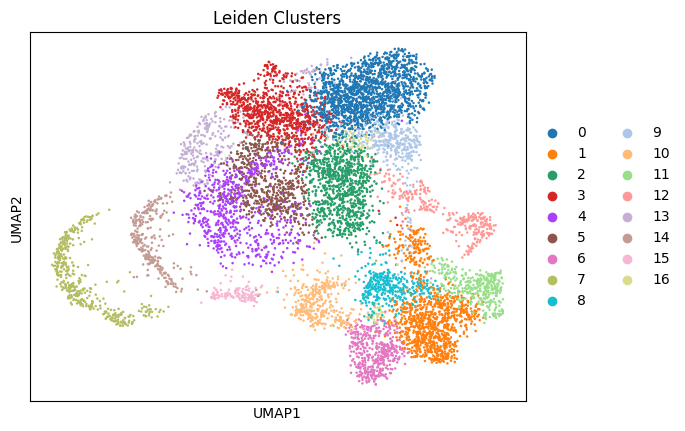

In [89]:

# 将 encoded_data 转换为 AnnData 对象
adata_encoded = AnnData(encoded_data)

# 计算邻居图
sc.pp.neighbors(adata_encoded)
sc.tl.leiden(adata_encoded)
sc.tl.umap(adata_encoded)
sc.pl.umap(adata_encoded, color='leiden', title='Leiden Clusters')

In [90]:

# 假设 rna.obs['cell_type'] 存储了原始标签
true_labels = rna.obs['cell_type']
predicted_labels = adata_encoded.obs['leiden']

# 计算 ARI
ari_score = adjusted_rand_score(true_labels, predicted_labels)
print(f'Adjusted Rand Index (ARI): {ari_score}')

# 计算 ACC 的辅助函数
def calculate_accuracy(true_labels, predicted_labels):
    contingency = contingency_matrix(true_labels, predicted_labels)
    row_ind, col_ind = linear_sum_assignment(-contingency)
    return contingency[row_ind, col_ind].sum() / np.sum(contingency)

# 计算 ACC
acc_score = calculate_accuracy(true_labels, predicted_labels)
print(f'Accuracy (ACC): {acc_score}')


Adjusted Rand Index (ARI): 0.25652162300145
Accuracy (ACC): 0.4368879216539717


In [ ]:


# 使用Elbow方法和轮廓系数确定聚类数
wcss = []
silhouette_scores = []
K_max = 30  # 假设最多测试到40个聚类

for k in range(2, K_max+1):
    kmeans = KMeans(n_clusters=k, random_state=42)
    print(k)
    kmeans.fit(X_pca)
    wcss.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_pca, kmeans.labels_))

# 绘制WSS(Elbow Method)的图
plt.figure(figsize=(12, 6))
plt.plot(range(2, K_max+1), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

# 绘制轮廓系数的图
plt.figure(figsize=(12, 6))
plt.plot(range(2, K_max+1), silhouette_scores, marker='o')
plt.title('Silhouette Score')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

# 选择轮廓系数最高的k值
optimal_k = range(2, K_max+1)[silhouette_scores.index(max(silhouette_scores))]
print(f'Optimal number of clusters: {optimal_k}')


In [ ]:
from sklearn.cluster import KMeans

# 应用 k-means 聚类
kmeans = KMeans(n_clusters=22)
clusters = kmeans.fit_predict(encoded_data)

# 把聚类结果存回adata对象
adata.obs['clusters'] = clusters.astype(str)


In [ ]:
sc.tl.pca(adata)
sc.pl.pca_scatter(adata, color='clusters')

In [ ]:
adata = ad.read_h5ad('dataset1.h5ad')

# 假设真实标签存储在.obs的一个字段中，例如'field_with_labels'
#true_labels = adata.obs['cell_type']

In [ ]:
# Visualize Dataset
sc.pp.filter_cells(adata, min_genes=200)   # 筛选至少包含 200 个基因的细胞
sc.pp.filter_genes(adata, min_cells=3)     # 筛选至少在 3 个细胞中出现的基因
sc.pp.normalize_total(adata, target_sum=1e4)  # 数据标准化
sc.pp.log1p(adata)  # 对数据进行对数转换
sc.pp.highly_variable_genes(adata, n_top_genes=2000)  # 检测高变异基因
adata = adata[:, adata.var.highly_variable]  # 保留高变异基因

# 降维分析（PCA）
sc.tl.pca(adata, svd_solver='arpack')

# 计算邻居图
sc.pp.neighbors(adata)

# 聚类
sc.tl.louvain(adata)

# 进行 t-SNE 可视化
sc.tl.tsne(adata)
sc.pl.tsne(adata, color=['louvain',kmeans_clusters])

In [ ]:
sc.pl.tsne(adata, color=['louvain','kmeans_clusters'])

In [ ]:
# KMeans 聚类的 t-SNE 图
sc.pl.tsne(adata, color='kmeans_clusters', title='KMeans Clusters')

# KMeans 聚类的 UMAP 图
sc.pl.umap(adata, color='kmeans_clusters', title='KMeans Clusters')
